In [37]:
%load_ext autoreload
%autoreload 2
import sys
import os
import numpy as np

sys.path.append(os.path.abspath('../../Cochlear_Implant_Hackathon/'))

from software.models.minimal_model import basic_model
from software.fitness_functions.delta_wav import compute_wavfile_delta,wavefile_correlation,convert_sample_rate,wavefile_max_xcor
# Import the rest of the GpyT subpackage functions for the demo here

from software.AB_imports.Demo.proceduralDemo import demo4_procedural
from scipy.fftpack import fft,rfft,irfft,ifft
from sklearn.preprocessing import StandardScaler
import pyaudio as pa
from scipy.signal import resample, correlate
from scipy.io.wavfile import read as wavread
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
try:
    plt.style.use('rossidata')
except:
    pass



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading Original Demo


In [5]:
input_file_path=os.path.abspath('../sample_data/sentence1_55_clean.wav')

results  = demo4_procedural(input_file_path)

/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/NoiseReduction/noiseReduction.py:76: RuntimeWarning: divide by zero encountered in log10
  logA = np.maximum(-100,20*np.log10(A))
/Users/nicholas.rossi/Documents/Personal/Cochlear_Implant_Hackathon/software/AB_imports/Validation/validateOutput.py:81: UserWarning: No Validation file found! Validation process will be skipped, results may not be accepted for final entry submission!!
  warnings.warn('No Validation file found! Validation process will be skipped, results may not be accepted for final entry submission!!')


# demo performance
This is the original transformation model, this is meant for benchmarking

In [32]:
wavIn = wavread(results['sourceName'])
wavData = wavIn[1]/(2**15-1)
wavFs = wavIn[0]

wavResampled = resample(wavData,((results['audioFs']/wavFs)*wavData.shape[0]).astype(int))
input1 = np.float32(np.concatenate((wavResampled,np.zeros(results['audioFs']))))

output1 = np.float32(np.concatenate((np.zeros(results['audioFs']),results['audioOut'])))
p = pa.PyAudio()
devInfo = p.get_default_output_device_info()
devIndex = devInfo['index']
nChan = 1

stream = p.open(format=pa.paFloat32,
channels=nChan,
rate=results['audioFs'],
output=True,
output_device_index = devIndex
)

inData = input1.astype(np.float32).tobytes()
outData1 = output1.astype(np.float32).tobytes()


stream.write(outData1)


stream.write(inData)
stream.close()


In [35]:
wavefile_correlation(wavIn[1]/(2**15-1),wavIn[0],results['audioOut'],results['audioFs'])

0.010244097272993668

In [39]:
wavefile_max_xcor(wavIn[1],wavIn[0],results['audioOut'],results['audioFs'])

0.01628513351671649

In [31]:
demo_score=compute_wavfile_delta(wavIn[1],wavIn[0],results['audioOut'],results['audioFs'])
print(f'Demo Score : {demo_score}')

Demo Score : 1.0641884803771973


In [24]:
ref_remastered = convert_sample_rate(wavIn[1],wavIn[0])
output_remastered = convert_sample_rate(results['audioOut'],results['audioFs'])

In [30]:
a=ref_remastered
b=ref_remastered
a = (a - np.mean(a)) / (np.std(a) * len(a))
b = (b - np.mean(b)) / (np.std(b))
c = np.correlate(a, b, 'full')

print(max(c))

0.999999999999998


# Minimal model performance
This is the performance of the minimal model, it's doing the absolute basics to return a rational answer

In [ ]:
correlate

In [45]:
results=basic_model(input_file_path)

In [46]:
# Testing Audio Files

In [47]:
wavIn = wavread(results['sourceName'])
wavData = wavIn[1]/(2**15-1)
wavFs = wavIn[0]

wavResampled = resample(wavData,((results['audioFs']/wavFs)*wavData.shape[0]).astype(int))
input1 = np.float32(np.concatenate((wavResampled,np.zeros(results['audioFs']))))

output1 = np.float32(np.concatenate((np.zeros(results['audioFs']),results['audioOut'])))
p = pa.PyAudio()
devInfo = p.get_default_output_device_info()
devIndex = devInfo['index']
nChan = 1

stream = p.open(format=pa.paFloat32,
channels=nChan,
rate=results['audioFs'],
output=True,
output_device_index = devIndex
)

inData = input1.astype(np.float32).tobytes()
outData1 = output1.astype(np.float32).tobytes()


stream.write(outData1)


stream.write(inData)
stream.close()

In [41]:
minimal_model_score=compute_wavfile_delta(wavIn[1],wavIn[0],results['audioOut'],results['audioFs'])
print(f'Minimal model Score : {minimal_model_score} ')



Minimal model Score : 1.0641884803771973 


In [42]:
perfect_score=compute_wavfile_delta(wavIn[1],wavIn[0],wavIn[1],wavIn[0])

Text(0.5, 1.0, 'Scores \n (higher = better)')

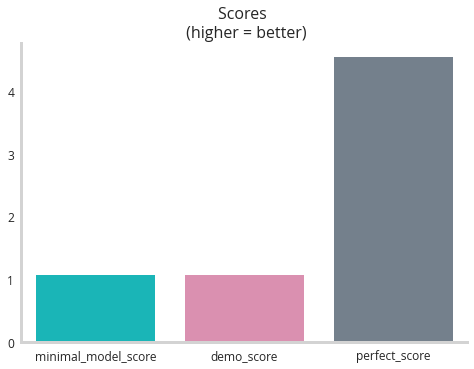

In [43]:
fig,ax=plt.subplots()
data=pd.DataFrame({'minimal_model_score':minimal_model_score,
'demo_score':demo_score,'perfect_score':perfect_score},index=[0])

sns.barplot(data=data,ax=ax)
ax.set_title('Scores \n (higher = better)')

In [163]:
perfect_score

4.548638343811035

In [48]:
wavefile_max_xcor(wavIn[1],wavIn[0],results['audioOut'],results['audioFs'])

0.01614036003608541

In [ ]:
0.01628513351671649